In [10]:
# Analysis 
import numpy as np
import datetime as dt  
from netCDF4 import Dataset  
from ncdump import ncdump
import gdal
import importlib
# Plotting 
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
# User-defined
from VPRM_params import NLCD_def, bbox                 # land cover
from VPRM_params import delT_day, delT_nig, x_pt, y_pt # UHI
from VPRM_fun import get_Tscale, get_UHI_deltT
from VPRMout_fun import Read_VPRMout,latlon_to_EPSG32618,find_a_point_in_grids
 

In [17]:
# Load NetCDF files
VPRMoutDir = '/data0/dwei/VPRMout/'
filepath = VPRMoutDir+'UHI4C_for0801_20220303.nc' 
GEE, Res, NEE, time, Xdim, Ydim, TMP = Read_VPRMout(filepath)
print(np.shape(GEE))
print(np.shape(Res))
print(np.shape(NEE))
print(np.shape(time))
print(np.shape(Xdim))
print(np.shape(Ydim))

# Some conversions
times_dt = [dt.datetime.fromtimestamp(t) for t in time] # convert timestamps to datetime
X_2D, Y_2D  = np.meshgrid(Xdim, Ydim)


(24, 1560, 1546)
(24, 1560, 1546)
(24, 1560, 1546)
(24,)
(1546,)
(1560,)


(array([11]),)


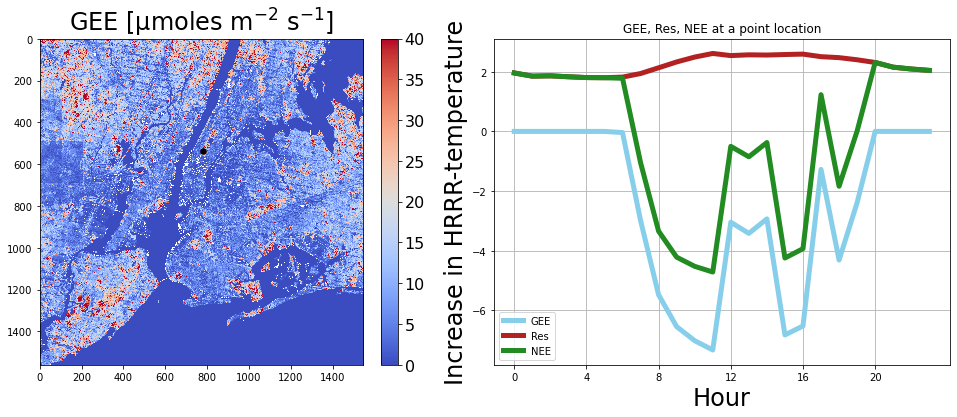

In [18]:
# Pick a loction using lat, lon to get the time series
CTPK = [40.772351, -73.974423]                  # central park
WLCT = (40.89050576788395, -73.87268730819294)  # Woodlawn cemetary
x,y = latlon_to_EPSG32618(CTPK) 
x_ind,y_ind=find_a_point_in_grids(x, y, Xdim, Ydim)
# print('The point we want :',x,y)
# print('The index are :', x_ind, y_ind)
# print(type(x_ind))

# Pick an hour solely for 2D plotting purposes
Datetime  = dt.datetime(2021, 8, 1, 11, 0, 0)
time_ind  = np.where(time==dt.datetime.timestamp(Datetime))
print(time_ind)
time_ind  = np.array(time_ind)[0][0]
GEE_hr    = GEE[time_ind,:,:]

# Plot the diurnal cycles of GEE, Res, NEE of interest
date_dt = dt.date(2021, 8, 1)
dates = [t.date() for t in times_dt]
day_ind = [date==date_dt for date in dates]
GEE_plt = GEE[day_ind, x_ind, y_ind].flatten()
Res_plt = Res[day_ind, x_ind, y_ind].flatten()
NEE_plt = NEE[day_ind, x_ind, y_ind].flatten()

fig = plt.figure(figsize=(18,6)) #plt.subplots(2, 2, figsize=(15,6))
plt.rcParams['axes.facecolor'] = 'w'
FontSize = 24
row = 1
col = 2
hours = range(0, 24)
LineWidth = 5

# GEE image
ax = fig.add_subplot(row, col, 1)
ax.set_title('GEE [\u03BCmoles m$^{-2}$ s$^{-1}$]', fontsize = FontSize)
im_gee = ax.imshow(-GEE_hr, interpolation='none', vmin = 0, vmax = 40, cmap='coolwarm')
cbar = plt.colorbar(im_gee,ax=ax,fraction=0.046, pad=0.04) # magic numbers fraction and pad!
cbar.ax.tick_params(labelsize=FontSize-8)
# add a point to an image
# ax.annotate('25, 50', xy=(x_int, y_int), xycoords='data',
#              xytext=(1, 1), textcoords='figure fraction',
#              arrowprops=dict(arrowstyle="->"))
ax.scatter(x_ind[0], y_ind[0], s=30, c='black', marker='o')

ax = fig.add_subplot(row, col, 2)
ax.set_title('GEE, Res, NEE at a point location')
ax.plot(hours, GEE_plt, color='skyblue', label='GEE', linewidth=LineWidth)
ax.plot(hours, Res_plt, color='firebrick', label='Res', linewidth=LineWidth)
ax.plot(hours, NEE_plt, color='forestgreen', label='NEE', linewidth=LineWidth)
ax.set_xticks(range(0, 24, 4))
ax.set_ylabel('Increase in HRRR-temperature', fontsize = FontSize)
ax.set_xlabel('Hour', fontsize = FontSize)
ax.legend(loc=0)
ax.grid()

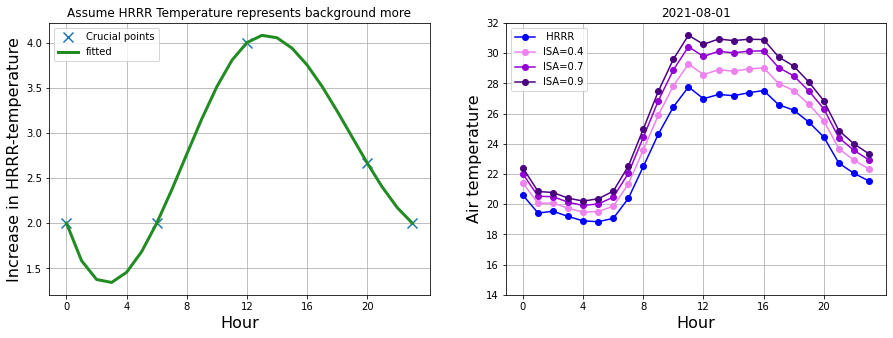

In [19]:
# Pick a day to get the time series of temperature
# date_dt = dt.date(2021, 6, 18)
# dates = [t.date() for t in times_dt]
# day_ind = [date==date_dt for date in dates]
T_hrrr = TMP[day_ind, x_ind, y_ind].flatten()
GEE_plt = GEE[day_ind, x_ind, y_ind].flatten()
Res_plt = Res[day_ind, x_ind, y_ind].flatten()
NEE_plt = NEE[day_ind, x_ind, y_ind].flatten()

# Get the modified delta temperature due to UHI
hours = range(0,24)
ynew = get_UHI_deltT()

# Get the modified temperature based on ISA
ISA = [0.4, 0.7, 0.9]      # corresponds to DEL, DEM, DEH
T_p_DEL = ynew*ISA[0]+T_hrrr
T_p_DEM = ynew*ISA[1]+T_hrrr
T_p_DEH = ynew*ISA[2]+T_hrrr

# Plot the temperature
fig = plt.figure(figsize=(15, 5))
row = 1
col = 2
FontSize = 16
MarkerSize = 100
LineWidth = 3

ax = fig.add_subplot(row, col, 1)
ax.set_title('Assume HRRR Temperature represents background more')
ax.scatter(x_pt, y_pt, marker='x', label='Crucial points', s = MarkerSize)
ax.plot(hours, ynew, color='forestgreen', label='fitted', linewidth=LineWidth)
ax.set_xticks(range(0, 24, 4))
ax.set_ylabel('Increase in HRRR-temperature', fontsize = FontSize)
ax.set_xlabel('Hour', fontsize = FontSize)
ax.legend(loc=2)
ax.grid()

ax = fig.add_subplot(row, col, 2)
ax.set_title(date_dt)
ax.plot(T_hrrr, marker='o', color='b', label=' HRRR')
ax.plot(T_p_DEL, marker='o', color='violet', label='ISA='+str(ISA[0]))
ax.plot(T_p_DEM, marker='o', color='darkviolet', label='ISA='+str(ISA[1]))
ax.plot(T_p_DEH, marker='o', color='indigo', label='ISA='+str(ISA[2]))
ax.set_yticks(range(14, 34, 2))
ax.set_xticks(range(0, 24, 4))
ax.legend(loc=2)
ax.set_ylabel('Air temperature', fontsize = FontSize)
ax.set_xlabel('Hour', fontsize = FontSize)
ax.grid()



Text(0.5, 0, 'Tair [$^{0}$C]')

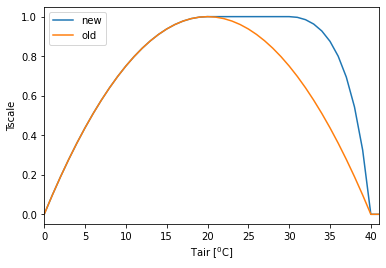

In [12]:
# Test the Tscale in VPRM
# DBF= (0, 30, 40, 5, 863, 0.09355, 0.1379, 1.09) # Winbourne et al. 2021 (Duke Forest)
# GRS= (2, 18, 40, 1, 542, 0.213, 0.028, 0.72)
Tmin = 0.0
Topt = 20.
Tmax = 40.

T = np.arange(0, 45, 1)

Ts_new = [get_Tscale(t, Tmin, Tmax) for t in T]
Ts_new = np.asarray(Ts_new)
Ts_new[Ts_new>1.0] = 1.0
Ts_new[Ts_new<0.0] = 0.0

tmp = (T-Tmin)*(T-Tmax)
Ts_old = tmp/(tmp-(T-Topt)**2)
Ts_old[Ts_old>1.0] = 1.0
Ts_old[Ts_old<0.0] = 0.0

plt.plot(T, Ts_new, label='new')
plt.plot(T, Ts_old, label='old')
plt.legend()
plt.xlim(0,41)

plt.ylabel('Tscale')
plt.xlabel('Tair [$^{0}$C]')
